##### Importing Necessary Packages

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
#import soundfile as sf
import os
import numpy as np
from PIL import Image
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import torch.onnx

%matplotlib inline

### Mounting drive, where RAVDESSS dataset has been uploaded

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Function to Create a List to store all the filenames under each folder

In [4]:
def file_search(dirname, ret, audio_file, list_avoid_dir=[]):
    filenames = os.listdir(dirname)

    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        audio_name = filename

        if os.path.isdir(full_filename) :
            if full_filename.split('/')[-1] in list_avoid_dir:
                continue
            else:
                file_search(full_filename, ret, list_avoid_dir)

        else:
            ret.append( full_filename )
            audio_file.append(audio_name)

In [5]:
list_files = []

##storing only the names of the audio file
audio_file = []
for x in range(24):

    ##converting the iteration to string
    check_iter = str(x)

    if x == 9:
      sess_name = 'Actor_' + str(x+1)
    elif len(check_iter) == 1:
        sess_name = 'Actor_0' + str(x+1)
    else:
        sess_name = 'Actor_' + str(x+1)
    path = '/content/drive/MyDrive/COMP9444/Project/archive/'+ sess_name + '/'
    file_search(path, list_files, audio_file)
    list_files = sorted(list_files)
    print (sess_name + ", #sum files: " + str(len(list_files)))

Actor_01, #sum files: 60
Actor_02, #sum files: 120
Actor_03, #sum files: 180
Actor_04, #sum files: 240
Actor_05, #sum files: 300
Actor_06, #sum files: 360
Actor_07, #sum files: 420
Actor_08, #sum files: 480
Actor_09, #sum files: 540
Actor_10, #sum files: 600
Actor_11, #sum files: 660
Actor_12, #sum files: 720
Actor_13, #sum files: 780
Actor_14, #sum files: 840
Actor_15, #sum files: 900
Actor_16, #sum files: 960
Actor_17, #sum files: 1020
Actor_18, #sum files: 1080
Actor_19, #sum files: 1140
Actor_20, #sum files: 1200
Actor_21, #sum files: 1260
Actor_22, #sum files: 1320
Actor_23, #sum files: 1380
Actor_24, #sum files: 1440


### Getting length of list to check

In [6]:
len(list_files)###total number of files in the directory

1440

## Process filenames from a list of file paths, extract the emotion class, and convert them into numeric representations with 0-based indexing and append it to the emotion_class list

In [7]:
emotion_class = []
for everyfile in list_files:
  if (everyfile.split('/')[-1].strip('.wav')):
    ##getting the actual audio file name
    filename = everyfile.split('/')[-1].strip('.wav')

    audio_file = filename.split('-')

    ##getting the emotion class
    label = audio_file[2]

    ##making the class labels as either '0', '1', '2', '3', '4', '5', '6', '7'
    number_label = int(label) - 1

    emotion_class.append(number_label)

Total Labels: 1440
Unique Labels and Counts:
Label 0: Count 96
Label 1: Count 192
Label 2: Count 192
Label 3: Count 192
Label 4: Count 192
Label 5: Count 192
Label 6: Count 192
Label 7: Count 192


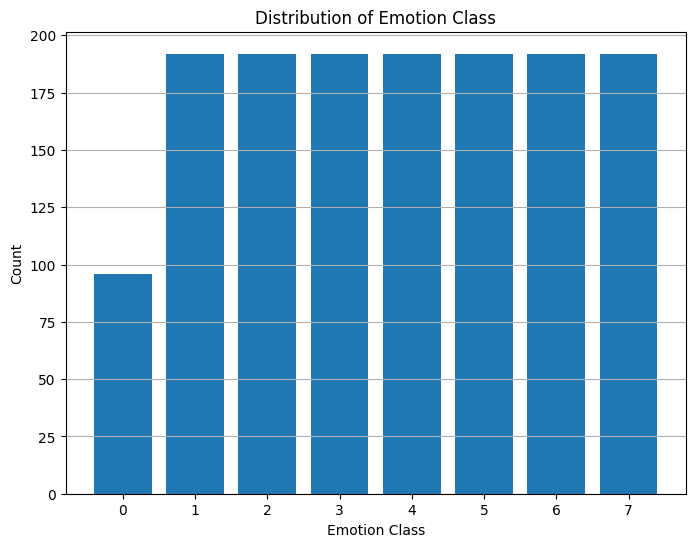

In [8]:
# Summary Statistics
labels_count = len(emotion_class)
unique_labels = np.unique(emotion_class, return_counts=True)

print(f"Total Labels: {labels_count}")
print("Unique Labels and Counts:")
for label, count in zip(unique_labels[0], unique_labels[1]):
    print(f"Label {label}: Count {count}")

# Histogram/Bar Plot
plt.figure(figsize=(8, 6))
plt.hist(emotion_class, bins=np.arange(min(emotion_class), max(emotion_class) + 2) - 0.5, rwidth=0.8)
plt.title('Distribution of Emotion Class')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.xticks(np.arange(min(emotion_class), max(emotion_class) + 1))
plt.grid(axis='y')
plt.show()


## Create a collection of dictionaries where each entry represents a file path along with its associated emotion label

In [10]:
data = []

for filenames, labels in zip(list_files, emotion_class):
  data.append({"path": filenames, "emotion_id": labels})

### Convert to a pandas dataframe for better manipulation

In [11]:
import pandas as pd

final_dataframe = pd.DataFrame(data)

In [12]:
final_dataframe

,path,emotion_id
0,/content/drive/MyDrive/COMP9444/Project/archiv...,0
1,/content/drive/MyDrive/COMP9444/Project/archiv...,0
2,/content/drive/MyDrive/COMP9444/Project/archiv...,0
3,/content/drive/MyDrive/COMP9444/Project/archiv...,0
4,/content/drive/MyDrive/COMP9444/Project/archiv...,1
...,...,...
1435,/content/drive/MyDrive/COMP9444/Project/archiv...,7
1436,/content/drive/MyDrive/COMP9444/Project/archiv...,7
1437,/content/drive/MyDrive/COMP9444/Project/archiv...,7
1438,/content/drive/MyDrive/COMP9444/Project/archiv...,7


### import necessary packages

In [13]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

## The AudioUtil class encapsulates static methods for audio preprocessing, including channel manipulation, resampling, signal padding/truncation, time shifting for augmentation, and spectrogram generation using MelSpectrogram and AmplitudeToDB transformations.

In [14]:
class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)



  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  ##same sample rates for each audio signal
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  ##resizing signals to the same length
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

    return (sig, sr)

  ###performing data augmentation by time shifting of audio signals
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=40, hop_len=20):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

In [15]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

## Prepare sound data by setting a standardized duration, sample rate, and channel specification, while utilizing methods from AudioUtil for operations like resampling, channel manipulation, duration adjustment, time shifting for augmentation, and spectrogram generation using MelSpectrogram transformations with specific parameters.

In [16]:
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)

  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.df.loc[idx, 'path']
    # Get the Class ID/ Emotion ID
    class_id = self.df.loc[idx, 'emotion_id']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return sgram, class_id

In [17]:
from torch.utils.data import random_split

myds = SoundDS(final_dataframe, list_files)

In [18]:
len(myds)

1440

## Preprocessing before training
### Determine size of myds dataset and randomly split into training and validation datasets

In [19]:
num_items = len(myds)

##Number of items in the Training Dataset
num_train = round(num_items * 0.8)

##Number of items in the Validation Dataset
num_val = num_items - num_train

##randomly splitting the data between training and valaidation dataset
train_ds, val_ds = random_split(myds, [num_train, num_val])

### Create data loaders, setting batch size 16 and shuffling training data to false

In [20]:
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [21]:
!pip install torch-summary

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [23]:
from torchsummary import summary

## Define Original AlexNet
###AlexNet Architecture is taken from https://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html

In [24]:
import torch.nn.functional as F
from torch.nn import init

class AlexNet(nn.Module):
    def __init__(self,num_classes: int = 8, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create the model and put it on the GPU if available
myModel = AlexNet()
summary(myModel)
print(summary)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       15,552
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

device(type='cuda', index=0)

#### Saving the model at the time having with best weights having lowest value in loss function

In [25]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))


## Define Training loop, with early stopping

In [26]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):

  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,anneal_strategy='linear')
  early_stop_thresh = 10
  best_accuracy = -1
  best_epoch = -1
  map_list = []
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set

    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        #print(data)
        #inputs, labels = data[0], torch.tensor(data[1])

        inputs = data[0].to(device)
        labels = data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        #print(outputs)



        labels_tens = torch.tensor(labels)

        #print(labels_tens)

        loss = criterion(outputs, labels_tens)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))





    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')


    if acc > best_accuracy:
      best_accuracy = acc
      best_epoch = epoch
      checkpoint(myModel, 'Best_Alexnet_model.pth')
    elif epoch - best_epoch > early_stop_thresh:
      print(f'Stopping early at epoch {epoch}')
      flag = 1
      #print(map_list)
      break
    else:
      checkpoint(myModel, 'last_model_Alexnet.pth')



num_epochs=150
training(myModel, train_dl, num_epochs)

<ipython-input-26-b180eda31080>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tens = torch.tensor(labels)


Epoch: 0, Loss: 1.96, Accuracy: 0.22
Epoch: 1, Loss: 1.87, Accuracy: 0.25
Epoch: 2, Loss: 1.86, Accuracy: 0.28
Epoch: 3, Loss: 1.81, Accuracy: 0.27
Epoch: 4, Loss: 1.83, Accuracy: 0.26
Epoch: 5, Loss: 1.80, Accuracy: 0.28
Epoch: 6, Loss: 1.79, Accuracy: 0.30
Epoch: 7, Loss: 1.75, Accuracy: 0.33
Epoch: 8, Loss: 1.68, Accuracy: 0.34
Epoch: 9, Loss: 1.66, Accuracy: 0.33
Epoch: 10, Loss: 1.62, Accuracy: 0.36
Epoch: 11, Loss: 1.57, Accuracy: 0.38
Epoch: 12, Loss: 1.53, Accuracy: 0.39
Epoch: 13, Loss: 1.54, Accuracy: 0.39
Epoch: 14, Loss: 1.51, Accuracy: 0.41
Epoch: 15, Loss: 1.48, Accuracy: 0.42
Epoch: 16, Loss: 1.43, Accuracy: 0.43
Epoch: 17, Loss: 1.39, Accuracy: 0.43
Epoch: 18, Loss: 1.46, Accuracy: 0.42
Epoch: 19, Loss: 1.39, Accuracy: 0.44
Epoch: 20, Loss: 1.39, Accuracy: 0.45
Epoch: 21, Loss: 1.31, Accuracy: 0.49
Epoch: 22, Loss: 1.27, Accuracy: 0.48
Epoch: 23, Loss: 1.31, Accuracy: 0.46
Epoch: 24, Loss: 1.24, Accuracy: 0.50
Epoch: 25, Loss: 1.21, Accuracy: 0.52
Epoch: 26, Loss: 1.24,

KeyboardInterrupt: ignored

In [27]:
resume(myModel, 'Best_Alexnet_model.pth')

## Evaluate trained model on validation dataset and print accuracy

In [28]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

In [31]:
bestmodel = AlexNet()
bestmodel.load_state_dict(torch.load('/content/Best_Alexnet_model.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bestmodel = bestmodel.to(device)
# Check that it is on Cuda
next(bestmodel.parameters()).device

device(type='cuda', index=0)

In [29]:
# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.72, Total items: 288


In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

<Axes: title={'center': 'Confusion Matrix for AlexNet'}>

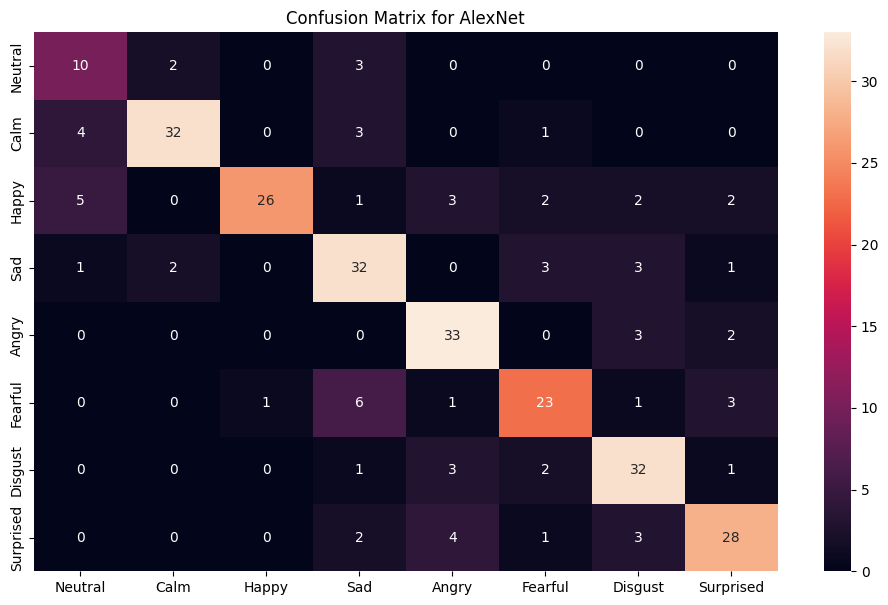

In [43]:
y_pred = []
y_true = []

# iterate over test data

for data in val_dl:
    # Get the input features and target labels, and put them on the GPU
    inputs, labels = data[0].to(device), data[1].to(device)

    # Normalize the inputs
    inputs_m, inputs_s = inputs.mean(), inputs.std()
    inputs = (inputs - inputs_m) / inputs_s

    # Get predictions
    outputs = bestmodel(inputs)

    # Get the predicted class with the highest score
    _, prediction = torch.max(outputs,1)

    final_pred_cpu = prediction.data.cpu().numpy()

    ##Appending the final output data
    y_pred.extend(final_pred_cpu)

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth


# constant for classes
classes = ('Neutral', 'Calm', 'Happy', 'Sad', 'Angry',
        'Fearful', 'Disgust', 'Surprised')

#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix for AlexNet')
sn.heatmap(df_cm, annot=True)

<Axes: title={'center': 'Confusion Matrix by AlexNet, results in probability'}>

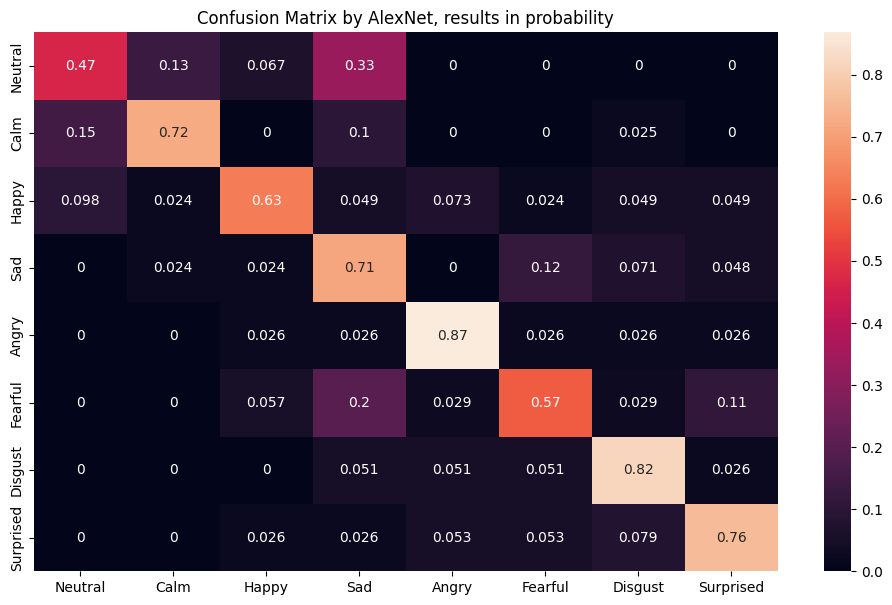

In [42]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix by AlexNet, results in probability')
sn.heatmap(df_cm, annot=True)

In [44]:
from sklearn.metrics import classification_report

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

              precision    recall  f1-score   support

     Neutral       0.50      0.67      0.57        15
        Calm       0.89      0.80      0.84        40
       Happy       0.96      0.63      0.76        41
         Sad       0.67      0.76      0.71        42
       Angry       0.75      0.87      0.80        38
     Fearful       0.72      0.66      0.69        35
     Disgust       0.73      0.82      0.77        39
   Surprised       0.76      0.74      0.75        38

    accuracy                           0.75       288
   macro avg       0.75      0.74      0.74       288
weighted avg       0.77      0.75      0.75       288

